In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
from keras import optimizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, History


if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from matplotlib.pyplot import figure
import datetime


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


**READING AND PRE-PROCESSING DATA:**

In [2]:
time_shift = -24
omrnr = 3



dataset_df = pd.read_csv("entso_NVE_interpolated.csv", index_col=[0])
dataset_df = pd.read_csv("entso_NVE_interpolated.csv", index_col=[0])
dataset_df[f'NO{omrnr}_day_ahead_prices (t+{time_shift*-1})'] = dataset_df[f'NO{omrnr}_day_ahead_prices'].shift(time_shift)



dataset_df_preprocessed = dataset_df.interpolate(method="linear", 
                                        limit_direction="backward", 
                                        limit=24)

dataset_df.head()

,Unnamed: 0.1,NO1_day_ahead_prices,NO1_Actual Load,NO1_Forecasted Load,NO1_generation_actual,NO1_generation_forecast,NO2_day_ahead_prices,NO2_Actual Load,NO2_Forecasted Load,NO2_generation_actual,NO2_generation_forecast,NO3_day_ahead_prices,NO3_Actual Load,NO3_Forecasted Load,NO3_generation_actual,NO3_generation_forecast,NO4_day_ahead_prices,NO4_Actual Load,NO4_Forecasted Load,NO4_generation_actual,NO4_generation_forecast,NO5_day_ahead_prices,NO5_Actual Load,NO5_Forecasted Load,NO5_generation_actual,NO5_generation_forecast,dato_id,NO1_Fyllingsgrad_NVE,NO2_Fyllingsgrad_NVE,NO3_Fyllingsgrad_NVE,NO4_Fyllingsgrad_NVE,NO5_Fyllingsgrad_NVE,NO3_day_ahead_prices (t+24)
0,2016-01-01 01:00:00+01:00,16.04,4482.0,4460.0,3272.0,1649.0,16.04,4010.0,4090.0,15388.0,7801.0,16.04,2402.0,2372.0,2860.0,1494.0,16.04,2047.0,2071.0,4628.0,2310.0,16.04,2188.0,2135.0,6506.0,3256.0,2016-01-01 01:00:00+01:00,0.652750,0.893212,0.730147,0.848484,0.762567,15.89
1,2016-01-01 02:00:00+01:00,15.74,4421.0,4401.0,3264.0,1640.0,15.74,3930.0,4001.0,14876.0,7423.0,15.74,2383.0,2361.0,2766.0,1454.0,15.74,2070.0,2082.0,4434.0,2227.0,15.74,2155.0,2115.0,6284.0,3160.0,2016-01-01 02:00:00+01:00,0.652462,0.893012,0.729909,0.848328,0.762300,15.03
2,2016-01-01 03:00:00+01:00,15.57,4335.0,4323.0,3250.0,1637.0,15.57,3839.0,3920.0,14242.0,7169.0,15.57,2362.0,2333.0,2712.0,1434.0,15.57,2032.0,2047.0,4294.0,2166.0,15.57,2139.0,2085.0,6110.0,3086.0,2016-01-01 03:00:00+01:00,0.652175,0.892811,0.729671,0.848171,0.762034,13.19
3,2016-01-01 04:00:00+01:00,15.47,4304.0,4279.0,3266.0,1642.0,15.47,3833.0,3925.0,14082.0,7049.0,15.47,2343.0,2314.0,2678.0,1411.0,15.47,2041.0,2055.0,4286.0,2156.0,15.47,2141.0,2090.0,6042.0,3041.0,2016-01-01 04:00:00+01:00,0.651887,0.892610,0.729433,0.848015,0.761767,12.69
4,2016-01-01 05:00:00+01:00,15.75,4336.0,4320.0,3272.0,1645.0,15.75,3944.0,4030.0,14492.0,7407.0,15.75,2362.0,2329.0,2752.0,1447.0,15.75,2069.0,2088.0,4490.0,2258.0,15.75,2168.0,2112.0,6234.0,3136.0,2016-01-01 05:00:00+01:00,0.651600,0.892409,0.729195,0.847859,0.761500,12.94


In [19]:


test,train = train_test_split(dataset_df_preprocessed, test_size=0.8, shuffle=False)
train, val = train_test_split(train, test_size=0.15, shuffle=False)


# Data columns
target_colums = [f"NO{omrnr}_day_ahead_prices (t+{time_shift*-1})"]
load_columns = [f"NO{i}_Actual Load" for i in range(1,6)][omrnr]
generated_columns = [f"NO{i}_generation_actual" for i in range(1,6)][omrnr]
nve_columns = [f"NO{i}_Fyllingsgrad_NVE" for i in range(1,6)][omrnr]

load_forecast_columns = [f"NO{i}_Forecasted Load" for i in range(1,6)][omrnr]
generated_forecast_columns = [f"NO{i}_generation_forecast" for i in range(1,6)][omrnr]

feature_columns =  [generated_forecast_columns] + [nve_columns] + [load_forecast_columns]


t_train = train[target_colums].to_numpy()
X_train = train[feature_columns].to_numpy()

t_val = val[target_colums].to_numpy()
X_val = val[feature_columns].to_numpy()

t_test = test[target_colums].to_numpy()
X_test = test[feature_columns].to_numpy()

# Scaling 
""""""
print(f"{X_train.shape}")
print(f"{t_train.shape}")
X_scaler = MinMaxScaler()
X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
X_val = X_scaler.transform(X_val)

t_scaler = MinMaxScaler()
t_scaler.fit(t_train.reshape(-1,1))
t_train = t_scaler.transform(t_train.reshape(-1,1)).flatten()
t_test = t_scaler.transform(t_test.reshape(-1,1)).flatten()
t_val = t_scaler.transform(t_val.reshape(-1,1)).flatten()

# Model shape 
time_steps = 100
nbf_features = X_train.shape[1]
print(nbf_features)
model_shape = (time_steps, nbf_features) 


X_train_m = X_train[35169-35000 + time_shift: time_shift].copy() #
t_train_m = t_train[35169-35000 + time_shift: time_shift].copy() # 

batch_size_train = X_train_m.shape[0] // time_steps
X_train_m = X_train_m.reshape((batch_size_train, time_steps, nbf_features))

t_train_m = t_train_m.reshape((batch_size_train, time_steps, 1))


# Validation data
X_val_m = X_val[6207-5000+ time_shift: time_shift].copy() #
t_val_m = t_val[6207-5000+ time_shift: time_shift].copy() # 

batch_size_val = X_val_m.shape[0] // time_steps
X_val_m = X_val_m.reshape((batch_size_val, time_steps, nbf_features))
t_val_m = t_val_m.reshape((batch_size_val, time_steps, 1))

# Test data
X_test_m = X_test[10344-10000+ time_shift: time_shift].copy() #
t_test_m = t_test[10344-10000+ time_shift: time_shift].copy() # 

batch_size_test = X_test_m.shape[0] // time_steps
X_test_m = X_test_m.reshape((batch_size_test, time_steps, nbf_features))
t_test_m = t_test_m.reshape((batch_size_test, time_steps, 1))




(35169, 3)
(35169, 1)
3


In [20]:
# X_test_m
np.count_nonzero(np.isnan(t_test_m))


0

**Implementing the LSTM:**

Epoch 1/5
2/2 [==============================] - 3s 737ms/step - loss: 0.1583 - val_loss: 0.0067 - lr: 0.0100
Epoch 2/5
2/2 [==============================] - 0s 194ms/step - loss: 0.0063 - val_loss: 0.0197 - lr: 0.0100
Epoch 3/5
2/2 [==============================] - 0s 206ms/step - loss: 0.0127 - val_loss: 0.0070 - lr: 0.0100
Epoch 4/5
2/2 [==============================] - 0s 189ms/step - loss: 0.0049 - val_loss: 0.0120 - lr: 0.0100
Epoch 5/5
2/2 [==============================] - 0s 228ms/step - loss: 0.0047 - val_loss: 0.0140 - lr: 0.0100
0.004011560697108507


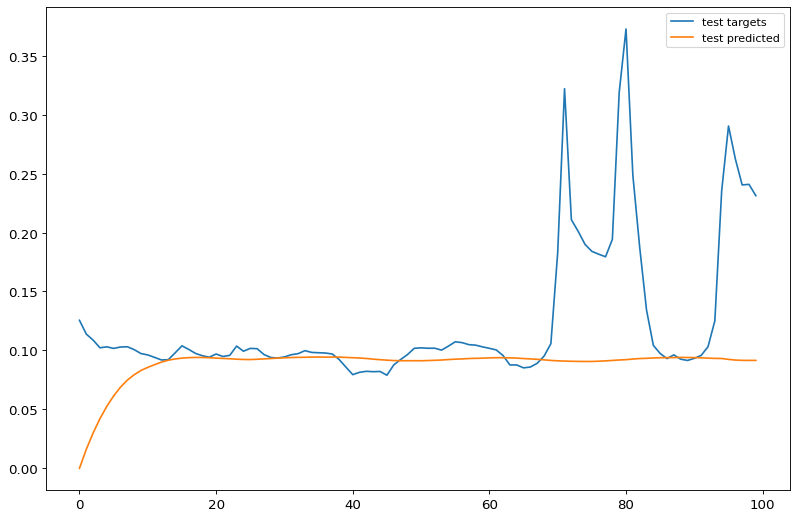

In [21]:
# Tensorboard
log_dir = f"data/report_data/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# log_dir = f"{REPORT_DATA}logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# Hyperparameters
eta = 0.01
rnn_units = 64
batch_size = 200
EPOCHS=5

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0001)

time_steps = 50
nbf_features = X_train.shape[1]
model_shape = (time_steps, nbf_features) 



model = keras.models.Sequential([
    keras.layers.LSTM(units = rnn_units, return_sequences=True,input_shape = [None,nbf_features]),
    # keras.layers.LSTM(units = rnn_units, input_shape = model_shape,return_sequences=True),
    # keras.layers.TimeDistributed(keras.layers.Dense(1))
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1)#,activation = 'sigmoid')
])

model.compile(loss="mse", optimizer= tf.keras.optimizers.Adam(learning_rate=eta))
history = model.fit(X_train_m, t_train_m, 
          shuffle=False, 
          batch_size=batch_size, 
          epochs=EPOCHS, 
          validation_data=(X_val_m, t_val_m),
          callbacks=[reduce_lr, tensorboard_callback],
          verbose=1)

t_hat_train = model.predict(X_train_m)
t_hat_test_m = model.predict(X_test_m)



test_MSE = MSE(t_test_m.flatten(), t_hat_test_m.flatten())



results = model.evaluate(X_test_m, t_test_m, verbose=0)

print(results)


figure(figsize=(12, 8), dpi=80)
x_plot = np.arange(t_test_m.flatten().shape[0])
plt.plot(x_plot[:100], t_test_m.flatten()[:100], label="test targets")
plt.plot(x_plot[:100], t_hat_test_m.flatten()[:100], label="test predicted")
#plt.xticks(test.loc[10344-10000: , 'dato_id'])
plt.legend()
plt.show()

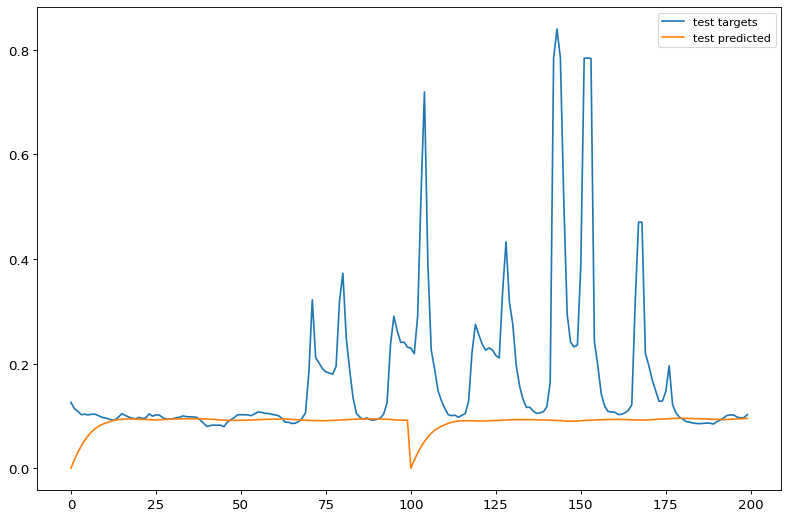

In [22]:


figure(figsize=(12, 8), dpi=80)
x_plot = np.arange(t_test_m.flatten().shape[0])
plt.plot(x_plot[:200], t_test_m.flatten()[:200], label="test targets")
plt.plot(x_plot[:200], t_hat_test_m.flatten()[:200], label="test predicted")
#plt.xticks(test.loc[10344-10000: , 'dato_id'])
plt.legend()
plt.show()

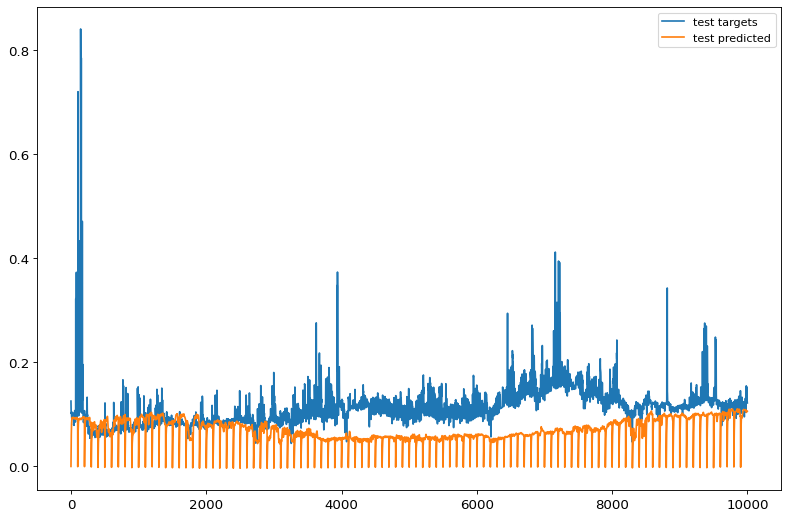

In [23]:


figure(figsize=(12, 8), dpi=80)
x_plot = np.arange(t_test_m.flatten().shape[0])
plt.plot(x_plot, t_test_m.flatten(), label="test targets")
plt.plot(x_plot, t_hat_test_m.flatten(), label="test predicted")
#plt.xticks(test.loc[10344-10000: , 'dato_id'])
plt.legend()
plt.show()

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)



plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()